## imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

import time
from gplearn.genetic import SymbolicTransformer
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import gc, mlcrate
from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import category_encoders as cat_ed
#will ignore all warning from sklearn, seaborn etc..

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [3]:
PATH = os.getcwd();
PATH

'D:\\Github\\fastai\\courses\\ml1'

In [4]:
df_raw  = pd.read_csv(f'{PATH}\\AV_Stud\\01_05_18_category_encoder_df_train.csv', low_memory= False)
df_test = pd.read_csv(f'{PATH}\\AV_Stud\\01_05_18_category_encoder_df_test.csv', low_memory=False)

In [5]:
target = df_raw.is_pass.values
df_raw.drop('is_pass',axis=1, inplace=True)

In [17]:
def Intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

In [37]:
len(Intersection(df_raw['trainee_id'].values, df_test['trainee_id'].values)),\
len(Intersection(df_raw['test_id'].values, df_test['test_id'].values))

(13857, 188)

In [22]:
len(np.unique(df_raw.trainee_id.values)), len(np.unique(df_test.trainee_id.values))

(18500, 14779)

In [26]:
df_raw['target'] = target
preds = df_test.trainee_id.map(df_raw.groupby('trainee_id')['target'].mean())
preds.fillna(method='ffill', inplace=True)
df_raw.drop('target', axis=1, inplace=True)

In [33]:
df_raw.head(2)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,program_duration,test_id,trainee_id,city_tier,age,total_programs_enrolled,is_age_39,is_age_39_45,is_age_45
0,1,3,3,1,1,0,2,1,2,2,136,150,9389,3,24.0,5,1.0,0.0,0.0
1,2,1,3,1,2,1,2,2,1,1,131,44,16523,4,26.0,2,1.0,0.0,0.0


In [38]:
df_raw['avg_prog_dur'] = df_raw['program_duration']/df_raw['total_programs_enrolled']
df_test['avg_prog_dur'] = df_test['program_duration']/df_test['total_programs_enrolled']

## new lib using category_encoder

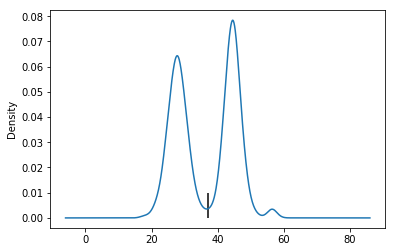

In [14]:
df_raw['age'].plot(kind='kde')
plt.vlines(37,0,0.01)

In [6]:
df_raw.head(1)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,program_duration,test_id,trainee_id,city_tier,age,total_programs_enrolled,is_age_39,is_age_39_45,is_age_45
0,1,3,3,1,1,0,2,1,2,2,136,150,9389,3,24.0,5,1.0,0.0,0.0


In [7]:
df_raw.drop(['id'], axis =1, inplace=True)
df_test.drop(['id'], axis =1, inplace=True)

In [8]:
df_raw['program_type__program_duration'] = df_raw.program_type.str.cat(df_raw.program_duration.astype(str),sep='_')
df_raw['test_id__program_duration'] = df_raw.test_id.astype(str).str.cat(df_raw.program_duration.astype(str),sep='_')
df_raw['test_id__test_type'] = df_raw.test_id.astype(str).str.cat(df_raw.test_type.astype(str),sep='_')
df_raw['test_type__difficulty_level'] = df_raw.test_type.str.cat(df_raw.difficulty_level.astype(str),sep='_')
df_raw['education__gender'] = df_raw.education.str.cat(df_raw.gender.astype(str),sep='_')
df_raw['education__city_tier'] = df_raw.education.str.cat(df_raw.city_tier.astype(str),sep='_')
df_raw['gender__city_tier'] = df_raw.gender.str.cat(df_raw.city_tier.astype(str),sep='_')
df_raw['trainee_engagement_rating']  = df_raw['trainee_engagement_rating'].astype(object)
########################### kind of binning age at trivial level #####################################

df_raw['is_age_39'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age<=39.').index
df_raw.iloc[my_query, -1] = 1
df_raw['is_age_39_45'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=39. & age<=45.').index
df_raw.iloc[my_query, -1] = 1
df_raw['is_age_45'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=45.').index
df_raw.iloc[my_query, -1] = 1

#######################################################################################################
###################young age (13–30), middle age (31–50) and senior age (51–70)########################
#######################################################################################################

df_raw['age_group'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=13. & age<=30.').index
df_raw.iloc[my_query, -1] = 'young'
my_query = df_raw.query('age>=31. & age<=50.').index
df_raw.iloc[my_query, -1] = 'middle_aged'
my_query = df_raw.query('age>=51. & age<=70.').index
df_raw.iloc[my_query, -1] = 'senior_aged'
###################################################################################################################
###################################################################################################################
###################################################################################################################

df_test['program_type__program_duration'] = df_test.program_type.str.cat(df_test.program_duration.astype(str),sep='_')
df_test['test_id__program_duration'] = df_test.test_id.astype(str).str.cat(df_test.program_duration.astype(str),sep='_')
df_test['test_id__test_type'] = df_test.test_id.astype(str).str.cat(df_test.test_type.astype(str),sep='_')
df_test['test_type__difficulty_level'] = df_test.test_type.str.cat(df_test.difficulty_level.astype(str),sep='_')
df_test['education__gender'] = df_test.education.str.cat(df_test.gender.astype(str),sep='_')
df_test['education__city_tier'] = df_test.education.str.cat(df_test.city_tier.astype(str),sep='_')
df_test['gender__city_tier'] = df_test.gender.str.cat(df_test.city_tier.astype(str),sep='_')
df_test['trainee_engagement_rating']  = df_test['trainee_engagement_rating'].astype(object)
########################### kind of binning age at trivial level #####################################

df_test['is_age_39'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age<=39.').index
df_test.iloc[my_query, -1] = 1
df_test['is_age_39_45'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=39. & age<=45.').index
df_test.iloc[my_query, -1] = 1
df_test['is_age_45'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=45.').index
df_test.iloc[my_query, -1] = 1

#######################################################################################################
###################young age (13–30), middle age (31–50) and senior age (51–70)########################
#######################################################################################################

df_test['age_group'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=13. & age<=30.').index
df_test.iloc[my_query, -1] = 'young'
my_query = df_test.query('age>=31. & age<=50.').index
df_test.iloc[my_query, -1] = 'middle_aged'
my_query = df_test.query('age>=51. & age<=70.').index
df_test.iloc[my_query, -1] = 'senior_aged';
###############################################################################

In [9]:
features = df_raw.columns
numeric_features = []
categorical_features = []

for dtype, feature in zip(df_raw.dtypes, df_raw.columns):
    if dtype == object:
        #print(column)
        #print(train_data[column].describe())
        categorical_features.append(feature)
    else:
        numeric_features.append(feature)
categorical_features

['program_id',
 'program_type',
 'test_type',
 'difficulty_level',
 'gender',
 'education',
 'is_handicapped',
 'trainee_engagement_rating',
 'program_type__program_duration',
 'test_id__program_duration',
 'test_id__test_type',
 'test_type__difficulty_level',
 'education__gender',
 'education__city_tier',
 'gender__city_tier',
 'age_group']

In [10]:
enc = cat_ed.hashing.HashingEncoder(2,cols=categorical_features, n_components= 10,drop_invariant=True)

In [11]:
enc.fit(df_raw, target)

HashingEncoder(cols=['program_id', 'program_type', 'test_type', 'difficulty_level', 'gender', 'education', 'is_handicapped', 'trainee_engagement_rating', 'program_type__program_duration', 'test_id__program_duration', 'test_id__test_type', 'test_type__difficulty_level', 'education__gender', 'education__city_tier', 'gender__city_tier', 'age_group'],
        drop_invariant=True, hash_method='md5', n_components=10,
        return_df=True, verbose=2)

In [12]:
df_raw = enc.transform(df_raw)

In [13]:
df_test = enc.transform(df_test)

In [14]:
df_raw.shape, df_test.shape

((73147, 19), (31349, 19))

## anokas

In [51]:
params = {}
params['booster'] = 'gbtree'
#params['updater'] = 'coord_descent'
params["objective"] = "binary:logistic"
params['eval_metric'] = 'auc'
params["eta"] = 0.05 #0.03
params["subsample"] = .85
params["silent"] = 0
params['verbose'] = 2
params["max_depth"] = 11
params["seed"] = 1
params["max_delta_step"] = 4
params['scale_pos_weight'] =  0.4380049934141978
params["gamma"] = 0.6 #.5 #.1 #.2
params['colsample_bytree'] = 0.9
params['nrounds'] = 2000 #3600 #2000 #4000 #using lower no for demo
params['max_leaves'] = 511

In [52]:
model, p_train, p_test, imps = mlcrate.xgb.train_kfold(params, df_raw, target, df_test, folds = 7, stratify=target, print_imp='final')

[mlcrate] Training 7 stratified XGBoost models on training set (73147, 20) with test set (31349, 20)
[mlcrate] Running fold 0, 62697 train samples, 10450 validation samples
[0]	train-auc:0.744755	valid-auc:0.667156
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.771816	valid-auc:0.685183
[2]	train-auc:0.779707	valid-auc:0.691154
[3]	train-auc:0.786306	valid-auc:0.696358
[4]	train-auc:0.791158	valid-auc:0.699105
[5]	train-auc:0.794934	valid-auc:0.700866
[6]	train-auc:0.799055	valid-auc:0.702848
[7]	train-auc:0.802149	valid-auc:0.705401
[8]	train-auc:0.804459	valid-auc:0.706938
[9]	train-auc:0.807047	valid-auc:0.708032
[10]	train-auc:0.809039	valid-auc:0.708208
[11]	train-auc:0.811514	valid-auc:0.708505
[12]	train-auc:0.815521	valid-auc:0.70881
[13]	train-auc:0.816756	valid-auc:0.708916
[14]	train-auc:0.818725	valid-auc:0.709598
[15]	train-auc:0.820795	valid-auc:0.710718
[16]	tr

[183]	train-auc:0.932156	valid-auc:0.745476
[184]	train-auc:0.932268	valid-auc:0.745511
[185]	train-auc:0.932375	valid-auc:0.745471
[186]	train-auc:0.932972	valid-auc:0.745752
[187]	train-auc:0.933159	valid-auc:0.745758
[188]	train-auc:0.933335	valid-auc:0.745817
[189]	train-auc:0.933463	valid-auc:0.745853
[190]	train-auc:0.933764	valid-auc:0.745996
[191]	train-auc:0.934185	valid-auc:0.746038
[192]	train-auc:0.934217	valid-auc:0.746063
[193]	train-auc:0.934431	valid-auc:0.745941
[194]	train-auc:0.934689	valid-auc:0.745916
[195]	train-auc:0.935155	valid-auc:0.746251
[196]	train-auc:0.935436	valid-auc:0.746482
[197]	train-auc:0.935731	valid-auc:0.746495
[198]	train-auc:0.935792	valid-auc:0.746484
[199]	train-auc:0.936268	valid-auc:0.746503
[200]	train-auc:0.936358	valid-auc:0.746513
[201]	train-auc:0.936573	valid-auc:0.746431
[202]	train-auc:0.936767	valid-auc:0.746549
[203]	train-auc:0.937032	valid-auc:0.746652
[204]	train-auc:0.937258	valid-auc:0.746812
[205]	train-auc:0.937357	valid-a

[371]	train-auc:0.967485	valid-auc:0.756802
[372]	train-auc:0.967565	valid-auc:0.756836
[373]	train-auc:0.967689	valid-auc:0.756848
[374]	train-auc:0.967723	valid-auc:0.756855
[375]	train-auc:0.967867	valid-auc:0.756888
[376]	train-auc:0.967975	valid-auc:0.756863
[377]	train-auc:0.968051	valid-auc:0.756877
[378]	train-auc:0.968102	valid-auc:0.756919
[379]	train-auc:0.968175	valid-auc:0.7569
[380]	train-auc:0.96824	valid-auc:0.756936
[381]	train-auc:0.968461	valid-auc:0.756967
[382]	train-auc:0.968623	valid-auc:0.757057
[383]	train-auc:0.96887	valid-auc:0.757144
[384]	train-auc:0.968948	valid-auc:0.757286
[385]	train-auc:0.969112	valid-auc:0.757238
[386]	train-auc:0.96914	valid-auc:0.757325
[387]	train-auc:0.969261	valid-auc:0.757452
[388]	train-auc:0.969317	valid-auc:0.757481
[389]	train-auc:0.969384	valid-auc:0.757451
[390]	train-auc:0.969433	valid-auc:0.757443
[391]	train-auc:0.969512	valid-auc:0.757515
[392]	train-auc:0.969658	valid-auc:0.757518
[393]	train-auc:0.969762	valid-auc:0.

[559]	train-auc:0.982616	valid-auc:0.762558
[560]	train-auc:0.982648	valid-auc:0.762575
[561]	train-auc:0.982709	valid-auc:0.762649
[562]	train-auc:0.982795	valid-auc:0.762662
[563]	train-auc:0.98281	valid-auc:0.762626
[564]	train-auc:0.982868	valid-auc:0.762619
[565]	train-auc:0.98289	valid-auc:0.762622
[566]	train-auc:0.982906	valid-auc:0.762596
[567]	train-auc:0.982978	valid-auc:0.762664
[568]	train-auc:0.983012	valid-auc:0.762546
[569]	train-auc:0.98303	valid-auc:0.762558
[570]	train-auc:0.983044	valid-auc:0.762518
[571]	train-auc:0.983127	valid-auc:0.762539
[572]	train-auc:0.983187	valid-auc:0.762522
[573]	train-auc:0.983272	valid-auc:0.762592
[574]	train-auc:0.98329	valid-auc:0.76264
[575]	train-auc:0.983331	valid-auc:0.76256
[576]	train-auc:0.983354	valid-auc:0.762616
[577]	train-auc:0.983363	valid-auc:0.762608
[578]	train-auc:0.98345	valid-auc:0.762744
[579]	train-auc:0.983465	valid-auc:0.762743
[580]	train-auc:0.983548	valid-auc:0.762832
[581]	train-auc:0.983594	valid-auc:0.76

[747]	train-auc:0.989474	valid-auc:0.765642
[748]	train-auc:0.989496	valid-auc:0.765595
[749]	train-auc:0.989525	valid-auc:0.765642
[750]	train-auc:0.989562	valid-auc:0.765708
[751]	train-auc:0.98958	valid-auc:0.765721
[752]	train-auc:0.989633	valid-auc:0.765737
[753]	train-auc:0.989671	valid-auc:0.765718
[754]	train-auc:0.989694	valid-auc:0.76575
[755]	train-auc:0.989716	valid-auc:0.765692
[756]	train-auc:0.989734	valid-auc:0.765736
[757]	train-auc:0.989747	valid-auc:0.765697
[758]	train-auc:0.989787	valid-auc:0.765719
[759]	train-auc:0.98983	valid-auc:0.765685
[760]	train-auc:0.989845	valid-auc:0.765738
[761]	train-auc:0.989894	valid-auc:0.765749
[762]	train-auc:0.98991	valid-auc:0.765738
[763]	train-auc:0.989954	valid-auc:0.76579
[764]	train-auc:0.989969	valid-auc:0.7658
[765]	train-auc:0.989996	valid-auc:0.765852
[766]	train-auc:0.990056	valid-auc:0.765879
[767]	train-auc:0.990054	valid-auc:0.765881
[768]	train-auc:0.990086	valid-auc:0.765985
[769]	train-auc:0.990133	valid-auc:0.76

[935]	train-auc:0.993442	valid-auc:0.768612
[936]	train-auc:0.993454	valid-auc:0.768573
[937]	train-auc:0.993466	valid-auc:0.768582
[938]	train-auc:0.993471	valid-auc:0.768627
[939]	train-auc:0.993491	valid-auc:0.768619
[940]	train-auc:0.993498	valid-auc:0.768637
[941]	train-auc:0.993522	valid-auc:0.768637
[942]	train-auc:0.993537	valid-auc:0.768656
[943]	train-auc:0.993549	valid-auc:0.768601
[944]	train-auc:0.993551	valid-auc:0.768607
[945]	train-auc:0.993559	valid-auc:0.768536
[946]	train-auc:0.99358	valid-auc:0.768617
[947]	train-auc:0.993585	valid-auc:0.768617
[948]	train-auc:0.993601	valid-auc:0.768634
[949]	train-auc:0.993608	valid-auc:0.768627
[950]	train-auc:0.993625	valid-auc:0.76863
[951]	train-auc:0.993639	valid-auc:0.768678
[952]	train-auc:0.993646	valid-auc:0.768686
[953]	train-auc:0.993665	valid-auc:0.76871
[954]	train-auc:0.993692	valid-auc:0.768796
[955]	train-auc:0.9937	valid-auc:0.76875
[956]	train-auc:0.993714	valid-auc:0.768714
[957]	train-auc:0.993726	valid-auc:0.7

[1120]	train-auc:0.995549	valid-auc:0.769878
[1121]	train-auc:0.995573	valid-auc:0.769857
[1122]	train-auc:0.995589	valid-auc:0.769871
[1123]	train-auc:0.995602	valid-auc:0.769904
[1124]	train-auc:0.995616	valid-auc:0.769911
[1125]	train-auc:0.995619	valid-auc:0.769955
[1126]	train-auc:0.995637	valid-auc:0.769933
[1127]	train-auc:0.995638	valid-auc:0.769919
[1128]	train-auc:0.995644	valid-auc:0.769923
[1129]	train-auc:0.995653	valid-auc:0.769912
[1130]	train-auc:0.995657	valid-auc:0.769922
[1131]	train-auc:0.995676	valid-auc:0.769999
[1132]	train-auc:0.995675	valid-auc:0.769987
[1133]	train-auc:0.995688	valid-auc:0.769998
[1134]	train-auc:0.9957	valid-auc:0.769977
[1135]	train-auc:0.995703	valid-auc:0.769972
[1136]	train-auc:0.995707	valid-auc:0.769982
[1137]	train-auc:0.995733	valid-auc:0.770027
[1138]	train-auc:0.995752	valid-auc:0.770095
[1139]	train-auc:0.995757	valid-auc:0.770111
[1140]	train-auc:0.99576	valid-auc:0.770109
[1141]	train-auc:0.99578	valid-auc:0.77011
[1142]	train-au

[1303]	train-auc:0.996864	valid-auc:0.771159
[1304]	train-auc:0.996871	valid-auc:0.771191
[1305]	train-auc:0.996876	valid-auc:0.771207
[1306]	train-auc:0.996879	valid-auc:0.771227
[1307]	train-auc:0.996895	valid-auc:0.771217
[1308]	train-auc:0.9969	valid-auc:0.771184
[1309]	train-auc:0.996905	valid-auc:0.771193
[1310]	train-auc:0.996909	valid-auc:0.771176
[1311]	train-auc:0.996911	valid-auc:0.771151
[1312]	train-auc:0.996912	valid-auc:0.771151
[1313]	train-auc:0.996911	valid-auc:0.771164
[1314]	train-auc:0.996915	valid-auc:0.771138
[1315]	train-auc:0.996919	valid-auc:0.771123
[1316]	train-auc:0.996924	valid-auc:0.771113
[1317]	train-auc:0.99693	valid-auc:0.771125
[1318]	train-auc:0.996939	valid-auc:0.771098
[1319]	train-auc:0.996944	valid-auc:0.771101
[1320]	train-auc:0.996947	valid-auc:0.771129
[1321]	train-auc:0.996956	valid-auc:0.77117
[1322]	train-auc:0.996966	valid-auc:0.771169
[1323]	train-auc:0.996969	valid-auc:0.771188
[1324]	train-auc:0.996973	valid-auc:0.771203
[1325]	train-a

[1487]	train-auc:0.997681	valid-auc:0.772171
[1488]	train-auc:0.997696	valid-auc:0.772162
[1489]	train-auc:0.9977	valid-auc:0.772153
[1490]	train-auc:0.997706	valid-auc:0.772148
[1491]	train-auc:0.997708	valid-auc:0.772142
[1492]	train-auc:0.997716	valid-auc:0.772091
[1493]	train-auc:0.99772	valid-auc:0.772054
[1494]	train-auc:0.997721	valid-auc:0.772089
[1495]	train-auc:0.997729	valid-auc:0.772058
[1496]	train-auc:0.997739	valid-auc:0.772075
[1497]	train-auc:0.997746	valid-auc:0.772134
[1498]	train-auc:0.997752	valid-auc:0.772172
[1499]	train-auc:0.997758	valid-auc:0.772209
[1500]	train-auc:0.99776	valid-auc:0.772197
[1501]	train-auc:0.997761	valid-auc:0.77219
[1502]	train-auc:0.997765	valid-auc:0.772178
[1503]	train-auc:0.997765	valid-auc:0.772196
[1504]	train-auc:0.997769	valid-auc:0.772223
[1505]	train-auc:0.99777	valid-auc:0.772197
[1506]	train-auc:0.997774	valid-auc:0.772223
[1507]	train-auc:0.997776	valid-auc:0.772227
[1508]	train-auc:0.99778	valid-auc:0.772217
[1509]	train-auc:

[1670]	train-auc:0.99823	valid-auc:0.772598
[1671]	train-auc:0.998232	valid-auc:0.772592
[1672]	train-auc:0.998233	valid-auc:0.772605
[1673]	train-auc:0.998237	valid-auc:0.772607
[1674]	train-auc:0.99824	valid-auc:0.772612
[1675]	train-auc:0.998241	valid-auc:0.772621
[1676]	train-auc:0.998242	valid-auc:0.772592
[1677]	train-auc:0.998244	valid-auc:0.772574
[1678]	train-auc:0.998246	valid-auc:0.772595
[1679]	train-auc:0.99825	valid-auc:0.772596
[1680]	train-auc:0.998253	valid-auc:0.772595
[1681]	train-auc:0.998259	valid-auc:0.772595
[1682]	train-auc:0.998261	valid-auc:0.77258
[1683]	train-auc:0.998263	valid-auc:0.772588
[1684]	train-auc:0.998264	valid-auc:0.772584
[1685]	train-auc:0.998265	valid-auc:0.772582
[1686]	train-auc:0.998268	valid-auc:0.7726
[1687]	train-auc:0.99827	valid-auc:0.772628
[1688]	train-auc:0.998273	valid-auc:0.772621
[1689]	train-auc:0.998277	valid-auc:0.772625
[1690]	train-auc:0.998278	valid-auc:0.772632
[1691]	train-auc:0.99828	valid-auc:0.772641
[1692]	train-auc:0

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 3m10s - running score 0.772775
[mlcrate] Running fold 1, 62697 train samples, 10450 validation samples
[0]	train-auc:0.744933	valid-auc:0.67904
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.766391	valid-auc:0.699385
[2]	train-auc:0.779451	valid-auc:0.711188
[3]	train-auc:0.786683	valid-auc:0.715513
[4]	train-auc:0.790587	valid-auc:0.71753
[5]	train-auc:0.79464	valid-auc:0.717742
[6]	train-auc:0.796438	valid-auc:0.71918
[7]	train-auc:0.799781	valid-auc:0.721123
[8]	train-auc:0.801824	valid-auc:0.722705
[9]	train-auc:0.8035	valid-auc:0.723673
[10]	train-auc:0.80534	valid-auc:0.724567
[11]	train-auc:0.808482	valid-auc:0.725905
[12]	train-auc:0.812039	valid-auc:0.727542
[13]	train-auc:0.813407	valid-auc:0.727025
[14]	train-auc:0.814963	valid-auc:0.727013
[15]	train-auc:0.816887	valid-auc:0.727607
[16]	train-auc:0.81856	valid-auc:0.728137

[184]	train-auc:0.932012	valid-auc:0.763767
[185]	train-auc:0.932102	valid-auc:0.763784
[186]	train-auc:0.932268	valid-auc:0.763819
[187]	train-auc:0.932568	valid-auc:0.764014
[188]	train-auc:0.932946	valid-auc:0.764024
[189]	train-auc:0.933235	valid-auc:0.76426
[190]	train-auc:0.933583	valid-auc:0.764399
[191]	train-auc:0.933844	valid-auc:0.764376
[192]	train-auc:0.934198	valid-auc:0.764483
[193]	train-auc:0.934596	valid-auc:0.764286
[194]	train-auc:0.934787	valid-auc:0.764388
[195]	train-auc:0.935235	valid-auc:0.764724
[196]	train-auc:0.93547	valid-auc:0.764746
[197]	train-auc:0.935983	valid-auc:0.765109
[198]	train-auc:0.936302	valid-auc:0.765166
[199]	train-auc:0.936516	valid-auc:0.765136
[200]	train-auc:0.936822	valid-auc:0.765152
[201]	train-auc:0.937138	valid-auc:0.765112
[202]	train-auc:0.937263	valid-auc:0.765174
[203]	train-auc:0.937703	valid-auc:0.765177
[204]	train-auc:0.937975	valid-auc:0.76519
[205]	train-auc:0.938475	valid-auc:0.76518
[206]	train-auc:0.938793	valid-auc:0

[371]	train-auc:0.968073	valid-auc:0.775385
[372]	train-auc:0.968216	valid-auc:0.775378
[373]	train-auc:0.968328	valid-auc:0.775262
[374]	train-auc:0.968512	valid-auc:0.775242
[375]	train-auc:0.968681	valid-auc:0.7752
[376]	train-auc:0.968794	valid-auc:0.775288
[377]	train-auc:0.968841	valid-auc:0.775357
[378]	train-auc:0.968955	valid-auc:0.775296
[379]	train-auc:0.969049	valid-auc:0.775191
[380]	train-auc:0.969115	valid-auc:0.775274
[381]	train-auc:0.969254	valid-auc:0.775293
[382]	train-auc:0.969377	valid-auc:0.775382
[383]	train-auc:0.969411	valid-auc:0.775432
[384]	train-auc:0.969558	valid-auc:0.775411
[385]	train-auc:0.969684	valid-auc:0.775512
[386]	train-auc:0.969858	valid-auc:0.775604
[387]	train-auc:0.970083	valid-auc:0.77573
[388]	train-auc:0.970112	valid-auc:0.775717
[389]	train-auc:0.970202	valid-auc:0.775789
[390]	train-auc:0.970242	valid-auc:0.775732
[391]	train-auc:0.970271	valid-auc:0.775732
[392]	train-auc:0.970347	valid-auc:0.775749
[393]	train-auc:0.970411	valid-auc:

[559]	train-auc:0.982847	valid-auc:0.779912
[560]	train-auc:0.98294	valid-auc:0.779971
[561]	train-auc:0.982994	valid-auc:0.780004
[562]	train-auc:0.983061	valid-auc:0.779958
[563]	train-auc:0.983074	valid-auc:0.77998
[564]	train-auc:0.983174	valid-auc:0.779909
[565]	train-auc:0.983197	valid-auc:0.7799
[566]	train-auc:0.983227	valid-auc:0.779935
[567]	train-auc:0.983305	valid-auc:0.779893
[568]	train-auc:0.983354	valid-auc:0.779843
[569]	train-auc:0.983387	valid-auc:0.779887
[570]	train-auc:0.983428	valid-auc:0.77985
[571]	train-auc:0.983476	valid-auc:0.779861
[572]	train-auc:0.983524	valid-auc:0.779873
[573]	train-auc:0.983535	valid-auc:0.77986
[574]	train-auc:0.983576	valid-auc:0.779822
[575]	train-auc:0.983642	valid-auc:0.779782
[576]	train-auc:0.983692	valid-auc:0.779814
[577]	train-auc:0.983751	valid-auc:0.779806
[578]	train-auc:0.983765	valid-auc:0.779832
[579]	train-auc:0.983832	valid-auc:0.779795
[580]	train-auc:0.983843	valid-auc:0.779785
[581]	train-auc:0.983897	valid-auc:0.7

[747]	train-auc:0.989925	valid-auc:0.782206
[748]	train-auc:0.989935	valid-auc:0.782204
[749]	train-auc:0.989971	valid-auc:0.78221
[750]	train-auc:0.989982	valid-auc:0.782225
[751]	train-auc:0.989991	valid-auc:0.782218
[752]	train-auc:0.990004	valid-auc:0.782176
[753]	train-auc:0.990014	valid-auc:0.782136
[754]	train-auc:0.990046	valid-auc:0.78217
[755]	train-auc:0.990058	valid-auc:0.782181
[756]	train-auc:0.990077	valid-auc:0.782228
[757]	train-auc:0.990095	valid-auc:0.782264
[758]	train-auc:0.990114	valid-auc:0.782284
[759]	train-auc:0.990161	valid-auc:0.782287
[760]	train-auc:0.990202	valid-auc:0.782254
[761]	train-auc:0.990212	valid-auc:0.782225
[762]	train-auc:0.990225	valid-auc:0.782281
[763]	train-auc:0.990272	valid-auc:0.78233
[764]	train-auc:0.99033	valid-auc:0.782387
[765]	train-auc:0.990351	valid-auc:0.782359
[766]	train-auc:0.990401	valid-auc:0.782344
[767]	train-auc:0.990417	valid-auc:0.782324
[768]	train-auc:0.990453	valid-auc:0.782329
[769]	train-auc:0.990468	valid-auc:0

[934]	train-auc:0.993689	valid-auc:0.783348
[935]	train-auc:0.993717	valid-auc:0.783354
[936]	train-auc:0.993731	valid-auc:0.783302
[937]	train-auc:0.993761	valid-auc:0.783381
[938]	train-auc:0.993775	valid-auc:0.783403
[939]	train-auc:0.993781	valid-auc:0.783447
[940]	train-auc:0.993785	valid-auc:0.783447
[941]	train-auc:0.993819	valid-auc:0.783492
[942]	train-auc:0.993826	valid-auc:0.783509
[943]	train-auc:0.993835	valid-auc:0.783496
[944]	train-auc:0.993857	valid-auc:0.78348
[945]	train-auc:0.993866	valid-auc:0.783507
[946]	train-auc:0.993876	valid-auc:0.783511
[947]	train-auc:0.993893	valid-auc:0.783547
[948]	train-auc:0.993894	valid-auc:0.783553
[949]	train-auc:0.993922	valid-auc:0.783599
[950]	train-auc:0.993935	valid-auc:0.783653
[951]	train-auc:0.993957	valid-auc:0.783685
[952]	train-auc:0.99397	valid-auc:0.783672
[953]	train-auc:0.993976	valid-auc:0.783738
[954]	train-auc:0.993978	valid-auc:0.783733
[955]	train-auc:0.99399	valid-auc:0.78372
[956]	train-auc:0.993996	valid-auc:0

[1119]	train-auc:0.995841	valid-auc:0.784987
[1120]	train-auc:0.995845	valid-auc:0.78498
[1121]	train-auc:0.995849	valid-auc:0.784994
[1122]	train-auc:0.995861	valid-auc:0.785
[1123]	train-auc:0.995869	valid-auc:0.784992
[1124]	train-auc:0.99587	valid-auc:0.784995
[1125]	train-auc:0.995873	valid-auc:0.785001
[1126]	train-auc:0.995878	valid-auc:0.785008
[1127]	train-auc:0.995884	valid-auc:0.784982
[1128]	train-auc:0.995886	valid-auc:0.784938
[1129]	train-auc:0.995893	valid-auc:0.784933
[1130]	train-auc:0.995899	valid-auc:0.784948
[1131]	train-auc:0.995905	valid-auc:0.784942
[1132]	train-auc:0.995916	valid-auc:0.78493
[1133]	train-auc:0.995925	valid-auc:0.784914
[1134]	train-auc:0.995926	valid-auc:0.784909
[1135]	train-auc:0.995933	valid-auc:0.784945
[1136]	train-auc:0.995944	valid-auc:0.784958
[1137]	train-auc:0.995947	valid-auc:0.785007
[1138]	train-auc:0.995963	valid-auc:0.784956
[1139]	train-auc:0.995967	valid-auc:0.784945
[1140]	train-auc:0.995978	valid-auc:0.78496
[1141]	train-auc:

[52]	train-auc:0.865749	valid-auc:0.726085
[53]	train-auc:0.866917	valid-auc:0.726629
[54]	train-auc:0.867694	valid-auc:0.726924
[55]	train-auc:0.868695	valid-auc:0.727108
[56]	train-auc:0.869443	valid-auc:0.727583
[57]	train-auc:0.870916	valid-auc:0.728306
[58]	train-auc:0.871874	valid-auc:0.728535
[59]	train-auc:0.872508	valid-auc:0.728611
[60]	train-auc:0.873307	valid-auc:0.728978
[61]	train-auc:0.874016	valid-auc:0.728954
[62]	train-auc:0.874614	valid-auc:0.729324
[63]	train-auc:0.874967	valid-auc:0.729405
[64]	train-auc:0.875508	valid-auc:0.729675
[65]	train-auc:0.876394	valid-auc:0.72999
[66]	train-auc:0.877323	valid-auc:0.73045
[67]	train-auc:0.878498	valid-auc:0.730783
[68]	train-auc:0.87891	valid-auc:0.731006
[69]	train-auc:0.879329	valid-auc:0.731119
[70]	train-auc:0.880075	valid-auc:0.731216
[71]	train-auc:0.880672	valid-auc:0.731364
[72]	train-auc:0.881183	valid-auc:0.731315
[73]	train-auc:0.88152	valid-auc:0.731474
[74]	train-auc:0.882362	valid-auc:0.731842
[75]	train-auc:

[241]	train-auc:0.945281	valid-auc:0.753587
[242]	train-auc:0.945573	valid-auc:0.753668
[243]	train-auc:0.945633	valid-auc:0.753715
[244]	train-auc:0.946078	valid-auc:0.753941
[245]	train-auc:0.946083	valid-auc:0.753979
[246]	train-auc:0.946382	valid-auc:0.754102
[247]	train-auc:0.946659	valid-auc:0.754212
[248]	train-auc:0.94699	valid-auc:0.754499
[249]	train-auc:0.947339	valid-auc:0.754704
[250]	train-auc:0.947532	valid-auc:0.754834
[251]	train-auc:0.947656	valid-auc:0.754795
[252]	train-auc:0.947778	valid-auc:0.754921
[253]	train-auc:0.948149	valid-auc:0.754972
[254]	train-auc:0.948365	valid-auc:0.7551
[255]	train-auc:0.948472	valid-auc:0.75511
[256]	train-auc:0.948759	valid-auc:0.755302
[257]	train-auc:0.948903	valid-auc:0.755383
[258]	train-auc:0.949033	valid-auc:0.755479
[259]	train-auc:0.949284	valid-auc:0.755564
[260]	train-auc:0.949452	valid-auc:0.75563
[261]	train-auc:0.949531	valid-auc:0.755684
[262]	train-auc:0.949624	valid-auc:0.755745
[263]	train-auc:0.949881	valid-auc:0.

[429]	train-auc:0.973044	valid-auc:0.76422
[430]	train-auc:0.973227	valid-auc:0.764195
[431]	train-auc:0.973354	valid-auc:0.764224
[432]	train-auc:0.973415	valid-auc:0.764255
[433]	train-auc:0.9736	valid-auc:0.764288
[434]	train-auc:0.973742	valid-auc:0.764454
[435]	train-auc:0.973852	valid-auc:0.76452
[436]	train-auc:0.973921	valid-auc:0.764558
[437]	train-auc:0.97397	valid-auc:0.764577
[438]	train-auc:0.97398	valid-auc:0.764611
[439]	train-auc:0.974104	valid-auc:0.764667
[440]	train-auc:0.974135	valid-auc:0.764642
[441]	train-auc:0.974317	valid-auc:0.764761
[442]	train-auc:0.97445	valid-auc:0.764738
[443]	train-auc:0.974483	valid-auc:0.764721
[444]	train-auc:0.974586	valid-auc:0.7648
[445]	train-auc:0.974702	valid-auc:0.764904
[446]	train-auc:0.97474	valid-auc:0.76487
[447]	train-auc:0.97483	valid-auc:0.764952
[448]	train-auc:0.974909	valid-auc:0.764976
[449]	train-auc:0.974948	valid-auc:0.764992
[450]	train-auc:0.974994	valid-auc:0.76503
[451]	train-auc:0.975093	valid-auc:0.765074
[

[617]	train-auc:0.985385	valid-auc:0.768313
[618]	train-auc:0.985457	valid-auc:0.768262
[619]	train-auc:0.985488	valid-auc:0.76821
[620]	train-auc:0.985525	valid-auc:0.768226
[621]	train-auc:0.985574	valid-auc:0.76822
[622]	train-auc:0.985605	valid-auc:0.768265
[623]	train-auc:0.985624	valid-auc:0.768307
[624]	train-auc:0.985647	valid-auc:0.768342
[625]	train-auc:0.985655	valid-auc:0.76835
[626]	train-auc:0.98568	valid-auc:0.768373
[627]	train-auc:0.985701	valid-auc:0.768393
[628]	train-auc:0.98576	valid-auc:0.768364
[629]	train-auc:0.985788	valid-auc:0.76838
[630]	train-auc:0.985786	valid-auc:0.768466
[631]	train-auc:0.985818	valid-auc:0.768521
[632]	train-auc:0.985842	valid-auc:0.768508
[633]	train-auc:0.985937	valid-auc:0.76848
[634]	train-auc:0.985987	valid-auc:0.768484
[635]	train-auc:0.986006	valid-auc:0.768539
[636]	train-auc:0.98602	valid-auc:0.76851
[637]	train-auc:0.986096	valid-auc:0.768519
[638]	train-auc:0.986108	valid-auc:0.768506
[639]	train-auc:0.986169	valid-auc:0.7685

[805]	train-auc:0.990932	valid-auc:0.771027
[806]	train-auc:0.990968	valid-auc:0.771005
[807]	train-auc:0.990991	valid-auc:0.771063
[808]	train-auc:0.991024	valid-auc:0.771123
[809]	train-auc:0.991041	valid-auc:0.77111
[810]	train-auc:0.991062	valid-auc:0.771175
[811]	train-auc:0.9911	valid-auc:0.771169
[812]	train-auc:0.991144	valid-auc:0.771151
[813]	train-auc:0.991162	valid-auc:0.771125
[814]	train-auc:0.991193	valid-auc:0.771163
[815]	train-auc:0.991221	valid-auc:0.771175
[816]	train-auc:0.991222	valid-auc:0.771221
[817]	train-auc:0.991241	valid-auc:0.77122
[818]	train-auc:0.991247	valid-auc:0.771215
[819]	train-auc:0.991283	valid-auc:0.771273
[820]	train-auc:0.991303	valid-auc:0.771259
[821]	train-auc:0.991311	valid-auc:0.771312
[822]	train-auc:0.991352	valid-auc:0.771371
[823]	train-auc:0.991393	valid-auc:0.771355
[824]	train-auc:0.991406	valid-auc:0.771409
[825]	train-auc:0.991424	valid-auc:0.771431
[826]	train-auc:0.991455	valid-auc:0.771373
[827]	train-auc:0.99147	valid-auc:0.

[993]	train-auc:0.994114	valid-auc:0.773088
[994]	train-auc:0.994139	valid-auc:0.773099
[995]	train-auc:0.994154	valid-auc:0.773104
[996]	train-auc:0.994157	valid-auc:0.773126
[997]	train-auc:0.994181	valid-auc:0.773081
[998]	train-auc:0.994206	valid-auc:0.773028
[999]	train-auc:0.99421	valid-auc:0.773039
[1000]	train-auc:0.994221	valid-auc:0.773002
[1001]	train-auc:0.994233	valid-auc:0.773017
[1002]	train-auc:0.994251	valid-auc:0.772998
[1003]	train-auc:0.994268	valid-auc:0.773067
[1004]	train-auc:0.994271	valid-auc:0.773099
[1005]	train-auc:0.994273	valid-auc:0.773102
[1006]	train-auc:0.994276	valid-auc:0.773108
[1007]	train-auc:0.994294	valid-auc:0.773105
[1008]	train-auc:0.994323	valid-auc:0.773156
[1009]	train-auc:0.994338	valid-auc:0.773075
[1010]	train-auc:0.994347	valid-auc:0.77311
[1011]	train-auc:0.994353	valid-auc:0.77311
[1012]	train-auc:0.994365	valid-auc:0.773128
[1013]	train-auc:0.994384	valid-auc:0.773126
[1014]	train-auc:0.994413	valid-auc:0.773135
[1015]	train-auc:0.9

[87]	train-auc:0.88738	valid-auc:0.735163
[88]	train-auc:0.887832	valid-auc:0.735434
[89]	train-auc:0.888246	valid-auc:0.735406
[90]	train-auc:0.889036	valid-auc:0.735485
[91]	train-auc:0.889341	valid-auc:0.735662
[92]	train-auc:0.889655	valid-auc:0.73579
[93]	train-auc:0.889932	valid-auc:0.735936
[94]	train-auc:0.890524	valid-auc:0.736133
[95]	train-auc:0.890753	valid-auc:0.73622
[96]	train-auc:0.891821	valid-auc:0.736572
[97]	train-auc:0.892725	valid-auc:0.736873
[98]	train-auc:0.89349	valid-auc:0.737213
[99]	train-auc:0.894182	valid-auc:0.737675
[100]	train-auc:0.894532	valid-auc:0.737711
[101]	train-auc:0.89496	valid-auc:0.737733
[102]	train-auc:0.895622	valid-auc:0.737949
[103]	train-auc:0.895859	valid-auc:0.738071
[104]	train-auc:0.896233	valid-auc:0.738223
[105]	train-auc:0.896813	valid-auc:0.738482
[106]	train-auc:0.897144	valid-auc:0.738421
[107]	train-auc:0.897571	valid-auc:0.738675
[108]	train-auc:0.897982	valid-auc:0.738908
[109]	train-auc:0.898759	valid-auc:0.739163
[110]	

[275]	train-auc:0.950172	valid-auc:0.755227
[276]	train-auc:0.950409	valid-auc:0.755151
[277]	train-auc:0.950565	valid-auc:0.755322
[278]	train-auc:0.950869	valid-auc:0.7555
[279]	train-auc:0.951055	valid-auc:0.75551
[280]	train-auc:0.951607	valid-auc:0.755685
[281]	train-auc:0.951772	valid-auc:0.755773
[282]	train-auc:0.951956	valid-auc:0.755706
[283]	train-auc:0.95207	valid-auc:0.755819
[284]	train-auc:0.952286	valid-auc:0.75593
[285]	train-auc:0.9525	valid-auc:0.756124
[286]	train-auc:0.952617	valid-auc:0.756115
[287]	train-auc:0.952956	valid-auc:0.756057
[288]	train-auc:0.953162	valid-auc:0.756039
[289]	train-auc:0.953288	valid-auc:0.756118
[290]	train-auc:0.953574	valid-auc:0.756152
[291]	train-auc:0.953851	valid-auc:0.75611
[292]	train-auc:0.953996	valid-auc:0.756153
[293]	train-auc:0.954125	valid-auc:0.756341
[294]	train-auc:0.95443	valid-auc:0.756343
[295]	train-auc:0.954709	valid-auc:0.756545
[296]	train-auc:0.954995	valid-auc:0.756673
[297]	train-auc:0.955278	valid-auc:0.7568

[463]	train-auc:0.975094	valid-auc:0.765575
[464]	train-auc:0.975248	valid-auc:0.765599
[465]	train-auc:0.97536	valid-auc:0.765648
[466]	train-auc:0.975404	valid-auc:0.765676
[467]	train-auc:0.975461	valid-auc:0.765768
[468]	train-auc:0.975546	valid-auc:0.765829
[469]	train-auc:0.975589	valid-auc:0.76585
[470]	train-auc:0.975678	valid-auc:0.765836
[471]	train-auc:0.975702	valid-auc:0.765816
[472]	train-auc:0.975822	valid-auc:0.765796
[473]	train-auc:0.975813	valid-auc:0.765802
[474]	train-auc:0.975923	valid-auc:0.765746
[475]	train-auc:0.975981	valid-auc:0.76572
[476]	train-auc:0.976052	valid-auc:0.765766
[477]	train-auc:0.976115	valid-auc:0.765815
[478]	train-auc:0.976198	valid-auc:0.765881
[479]	train-auc:0.976307	valid-auc:0.766039
[480]	train-auc:0.976341	valid-auc:0.766044
[481]	train-auc:0.976449	valid-auc:0.766165
[482]	train-auc:0.976533	valid-auc:0.766216
[483]	train-auc:0.97665	valid-auc:0.766349
[484]	train-auc:0.976701	valid-auc:0.766394
[485]	train-auc:0.976731	valid-auc:0

[650]	train-auc:0.985541	valid-auc:0.769955
[651]	train-auc:0.985565	valid-auc:0.770026
[652]	train-auc:0.985592	valid-auc:0.77003
[653]	train-auc:0.985624	valid-auc:0.770021
[654]	train-auc:0.98565	valid-auc:0.770037
[655]	train-auc:0.9857	valid-auc:0.770043
[656]	train-auc:0.98578	valid-auc:0.770045
[657]	train-auc:0.985841	valid-auc:0.769988
[658]	train-auc:0.985889	valid-auc:0.770002
[659]	train-auc:0.985901	valid-auc:0.770054
[660]	train-auc:0.985968	valid-auc:0.770092
[661]	train-auc:0.985993	valid-auc:0.770103
[662]	train-auc:0.986034	valid-auc:0.770135
[663]	train-auc:0.986067	valid-auc:0.77014
[664]	train-auc:0.986077	valid-auc:0.77018
[665]	train-auc:0.986126	valid-auc:0.770196
[666]	train-auc:0.986165	valid-auc:0.770151
[667]	train-auc:0.986178	valid-auc:0.770165
[668]	train-auc:0.986221	valid-auc:0.770199
[669]	train-auc:0.986289	valid-auc:0.770287
[670]	train-auc:0.986346	valid-auc:0.770261
[671]	train-auc:0.986418	valid-auc:0.770227
[672]	train-auc:0.986444	valid-auc:0.77

[838]	train-auc:0.991124	valid-auc:0.772542
[839]	train-auc:0.991168	valid-auc:0.77248
[840]	train-auc:0.991185	valid-auc:0.772491
[841]	train-auc:0.991191	valid-auc:0.772471
[842]	train-auc:0.991203	valid-auc:0.772509
[843]	train-auc:0.991212	valid-auc:0.772512
[844]	train-auc:0.991255	valid-auc:0.772487
[845]	train-auc:0.991272	valid-auc:0.772536
[846]	train-auc:0.991274	valid-auc:0.77254
[847]	train-auc:0.991273	valid-auc:0.77256
[848]	train-auc:0.991296	valid-auc:0.77253
[849]	train-auc:0.991328	valid-auc:0.772532
[850]	train-auc:0.991369	valid-auc:0.77258
[851]	train-auc:0.991374	valid-auc:0.772564
[852]	train-auc:0.991385	valid-auc:0.772625
[853]	train-auc:0.991404	valid-auc:0.772617
[854]	train-auc:0.991419	valid-auc:0.772636
[855]	train-auc:0.991436	valid-auc:0.7726
[856]	train-auc:0.991481	valid-auc:0.77261
[857]	train-auc:0.991492	valid-auc:0.772639
[858]	train-auc:0.991523	valid-auc:0.772653
[859]	train-auc:0.99153	valid-auc:0.772666
[860]	train-auc:0.991565	valid-auc:0.7725

[1025]	train-auc:0.994176	valid-auc:0.774029
[1026]	train-auc:0.99419	valid-auc:0.774117
[1027]	train-auc:0.994194	valid-auc:0.774098
[1028]	train-auc:0.994195	valid-auc:0.774083
[1029]	train-auc:0.994228	valid-auc:0.774066
[1030]	train-auc:0.994244	valid-auc:0.774092
[1031]	train-auc:0.994264	valid-auc:0.774119
[1032]	train-auc:0.99427	valid-auc:0.774125
[1033]	train-auc:0.994272	valid-auc:0.774105
[1034]	train-auc:0.99428	valid-auc:0.774157
[1035]	train-auc:0.994286	valid-auc:0.774148
[1036]	train-auc:0.994287	valid-auc:0.774161
[1037]	train-auc:0.994296	valid-auc:0.774149
[1038]	train-auc:0.994302	valid-auc:0.774172
[1039]	train-auc:0.994319	valid-auc:0.774215
[1040]	train-auc:0.99433	valid-auc:0.774216
[1041]	train-auc:0.994336	valid-auc:0.774225
[1042]	train-auc:0.994341	valid-auc:0.774179
[1043]	train-auc:0.994355	valid-auc:0.774207
[1044]	train-auc:0.994366	valid-auc:0.774247
[1045]	train-auc:0.994379	valid-auc:0.774324
[1046]	train-auc:0.994397	valid-auc:0.774307
[1047]	train-a

[1208]	train-auc:0.996044	valid-auc:0.775678
[1209]	train-auc:0.996055	valid-auc:0.7757
[1210]	train-auc:0.996061	valid-auc:0.775724
[1211]	train-auc:0.996065	valid-auc:0.77569
[1212]	train-auc:0.99607	valid-auc:0.775671
[1213]	train-auc:0.996072	valid-auc:0.775661
[1214]	train-auc:0.996082	valid-auc:0.775682
[1215]	train-auc:0.996088	valid-auc:0.775683
[1216]	train-auc:0.996089	valid-auc:0.775711
[1217]	train-auc:0.996097	valid-auc:0.77567
[1218]	train-auc:0.9961	valid-auc:0.775678
[1219]	train-auc:0.9961	valid-auc:0.77567
[1220]	train-auc:0.996103	valid-auc:0.775702
[1221]	train-auc:0.996126	valid-auc:0.775697
[1222]	train-auc:0.996139	valid-auc:0.775761
[1223]	train-auc:0.996139	valid-auc:0.775776
[1224]	train-auc:0.996142	valid-auc:0.775756
[1225]	train-auc:0.996152	valid-auc:0.775806
[1226]	train-auc:0.996168	valid-auc:0.775783
[1227]	train-auc:0.996176	valid-auc:0.775825
[1228]	train-auc:0.996195	valid-auc:0.775845
[1229]	train-auc:0.996203	valid-auc:0.775844
[1230]	train-auc:0.9

[1392]	train-auc:0.997237	valid-auc:0.776313
[1393]	train-auc:0.997242	valid-auc:0.776346
[1394]	train-auc:0.997243	valid-auc:0.77638
[1395]	train-auc:0.997255	valid-auc:0.776383
[1396]	train-auc:0.997262	valid-auc:0.776373
[1397]	train-auc:0.997262	valid-auc:0.776378
[1398]	train-auc:0.997265	valid-auc:0.776386
[1399]	train-auc:0.997266	valid-auc:0.776396
[1400]	train-auc:0.997265	valid-auc:0.776386
[1401]	train-auc:0.99727	valid-auc:0.776352
[1402]	train-auc:0.997277	valid-auc:0.77633
[1403]	train-auc:0.997279	valid-auc:0.776341
[1404]	train-auc:0.997284	valid-auc:0.776368
[1405]	train-auc:0.997284	valid-auc:0.776361
[1406]	train-auc:0.997289	valid-auc:0.776358
[1407]	train-auc:0.997294	valid-auc:0.776352
[1408]	train-auc:0.997299	valid-auc:0.776347
[1409]	train-auc:0.997305	valid-auc:0.776364
[1410]	train-auc:0.997306	valid-auc:0.776372
[1411]	train-auc:0.997314	valid-auc:0.776357
[1412]	train-auc:0.997318	valid-auc:0.776341
[1413]	train-auc:0.997323	valid-auc:0.77636
[1414]	train-a

[105]	train-auc:0.898545	valid-auc:0.743657
[106]	train-auc:0.899266	valid-auc:0.743819
[107]	train-auc:0.89957	valid-auc:0.74397
[108]	train-auc:0.899783	valid-auc:0.744067
[109]	train-auc:0.900797	valid-auc:0.74418
[110]	train-auc:0.901136	valid-auc:0.744314
[111]	train-auc:0.901612	valid-auc:0.744699
[112]	train-auc:0.902411	valid-auc:0.744849
[113]	train-auc:0.902888	valid-auc:0.744983
[114]	train-auc:0.903351	valid-auc:0.745133
[115]	train-auc:0.903761	valid-auc:0.745028
[116]	train-auc:0.905014	valid-auc:0.745537
[117]	train-auc:0.905619	valid-auc:0.745606
[118]	train-auc:0.905924	valid-auc:0.74578
[119]	train-auc:0.906691	valid-auc:0.746042
[120]	train-auc:0.906982	valid-auc:0.746146
[121]	train-auc:0.907394	valid-auc:0.746134
[122]	train-auc:0.907872	valid-auc:0.746306
[123]	train-auc:0.908166	valid-auc:0.746402
[124]	train-auc:0.908533	valid-auc:0.74653
[125]	train-auc:0.909063	valid-auc:0.746722
[126]	train-auc:0.909579	valid-auc:0.746784
[127]	train-auc:0.910107	valid-auc:0.

[292]	train-auc:0.956878	valid-auc:0.760678
[293]	train-auc:0.9571	valid-auc:0.7608
[294]	train-auc:0.9573	valid-auc:0.76075
[295]	train-auc:0.957528	valid-auc:0.760817
[296]	train-auc:0.957733	valid-auc:0.760783
[297]	train-auc:0.957878	valid-auc:0.760884
[298]	train-auc:0.958121	valid-auc:0.760796
[299]	train-auc:0.958237	valid-auc:0.76082
[300]	train-auc:0.958484	valid-auc:0.760852
[301]	train-auc:0.958592	valid-auc:0.760887
[302]	train-auc:0.958812	valid-auc:0.761004
[303]	train-auc:0.958941	valid-auc:0.761124
[304]	train-auc:0.959137	valid-auc:0.761272
[305]	train-auc:0.959299	valid-auc:0.761332
[306]	train-auc:0.959439	valid-auc:0.761316
[307]	train-auc:0.959643	valid-auc:0.761387
[308]	train-auc:0.959831	valid-auc:0.761396
[309]	train-auc:0.960237	valid-auc:0.761702
[310]	train-auc:0.960372	valid-auc:0.761778
[311]	train-auc:0.960501	valid-auc:0.761963
[312]	train-auc:0.960663	valid-auc:0.762029
[313]	train-auc:0.960774	valid-auc:0.762029
[314]	train-auc:0.960869	valid-auc:0.762

[480]	train-auc:0.97752	valid-auc:0.769033
[481]	train-auc:0.977579	valid-auc:0.769069
[482]	train-auc:0.977587	valid-auc:0.76904
[483]	train-auc:0.977697	valid-auc:0.769124
[484]	train-auc:0.977814	valid-auc:0.769183
[485]	train-auc:0.97788	valid-auc:0.769175
[486]	train-auc:0.977992	valid-auc:0.769265
[487]	train-auc:0.97804	valid-auc:0.769254
[488]	train-auc:0.978213	valid-auc:0.769169
[489]	train-auc:0.978297	valid-auc:0.769177
[490]	train-auc:0.978401	valid-auc:0.769276
[491]	train-auc:0.97851	valid-auc:0.769366
[492]	train-auc:0.978568	valid-auc:0.769285
[493]	train-auc:0.978695	valid-auc:0.769461
[494]	train-auc:0.978784	valid-auc:0.769542
[495]	train-auc:0.978836	valid-auc:0.76957
[496]	train-auc:0.978865	valid-auc:0.76959
[497]	train-auc:0.978923	valid-auc:0.769567
[498]	train-auc:0.979005	valid-auc:0.769634
[499]	train-auc:0.979095	valid-auc:0.769743
[500]	train-auc:0.97919	valid-auc:0.769827
[501]	train-auc:0.979203	valid-auc:0.769885
[502]	train-auc:0.979314	valid-auc:0.770

[668]	train-auc:0.987549	valid-auc:0.772897
[669]	train-auc:0.987595	valid-auc:0.77296
[670]	train-auc:0.98761	valid-auc:0.772963
[671]	train-auc:0.987653	valid-auc:0.772967
[672]	train-auc:0.987662	valid-auc:0.773014
[673]	train-auc:0.987722	valid-auc:0.773098
[674]	train-auc:0.987732	valid-auc:0.773042
[675]	train-auc:0.987743	valid-auc:0.773018
[676]	train-auc:0.987761	valid-auc:0.773061
[677]	train-auc:0.987803	valid-auc:0.773058
[678]	train-auc:0.987861	valid-auc:0.773158
[679]	train-auc:0.987897	valid-auc:0.773172
[680]	train-auc:0.987915	valid-auc:0.773202
[681]	train-auc:0.987948	valid-auc:0.773232
[682]	train-auc:0.987993	valid-auc:0.773316
[683]	train-auc:0.988029	valid-auc:0.773297
[684]	train-auc:0.988059	valid-auc:0.773316
[685]	train-auc:0.988073	valid-auc:0.77334
[686]	train-auc:0.988144	valid-auc:0.773349
[687]	train-auc:0.988169	valid-auc:0.773401
[688]	train-auc:0.988195	valid-auc:0.773438
[689]	train-auc:0.988243	valid-auc:0.773472
[690]	train-auc:0.988258	valid-auc:

[856]	train-auc:0.99224	valid-auc:0.775166
[857]	train-auc:0.99226	valid-auc:0.775181
[858]	train-auc:0.99228	valid-auc:0.775203
[859]	train-auc:0.992297	valid-auc:0.775208
[860]	train-auc:0.992306	valid-auc:0.775197
[861]	train-auc:0.992333	valid-auc:0.775206
[862]	train-auc:0.992359	valid-auc:0.775231
[863]	train-auc:0.992381	valid-auc:0.775211
[864]	train-auc:0.992388	valid-auc:0.775189
[865]	train-auc:0.992413	valid-auc:0.775258
[866]	train-auc:0.992415	valid-auc:0.775246
[867]	train-auc:0.99243	valid-auc:0.775229
[868]	train-auc:0.992435	valid-auc:0.77523
[869]	train-auc:0.992463	valid-auc:0.775198
[870]	train-auc:0.992475	valid-auc:0.775287
[871]	train-auc:0.992493	valid-auc:0.775239
[872]	train-auc:0.992511	valid-auc:0.775225
[873]	train-auc:0.992537	valid-auc:0.775252
[874]	train-auc:0.992561	valid-auc:0.775263
[875]	train-auc:0.992568	valid-auc:0.775263
[876]	train-auc:0.992573	valid-auc:0.775234
[877]	train-auc:0.992593	valid-auc:0.775245
[878]	train-auc:0.992605	valid-auc:0.

[1043]	train-auc:0.994826	valid-auc:0.776587
[1044]	train-auc:0.994837	valid-auc:0.776605
[1045]	train-auc:0.994851	valid-auc:0.776574
[1046]	train-auc:0.994857	valid-auc:0.776583
[1047]	train-auc:0.994866	valid-auc:0.776589
[1048]	train-auc:0.994876	valid-auc:0.776598
[1049]	train-auc:0.994887	valid-auc:0.776653
[1050]	train-auc:0.994895	valid-auc:0.776719
[1051]	train-auc:0.994897	valid-auc:0.776716
[1052]	train-auc:0.994901	valid-auc:0.776734
[1053]	train-auc:0.994928	valid-auc:0.776755
[1054]	train-auc:0.994938	valid-auc:0.776749
[1055]	train-auc:0.994962	valid-auc:0.776699
[1056]	train-auc:0.994974	valid-auc:0.776673
[1057]	train-auc:0.994977	valid-auc:0.776657
[1058]	train-auc:0.994986	valid-auc:0.776651
[1059]	train-auc:0.995005	valid-auc:0.776654
[1060]	train-auc:0.995016	valid-auc:0.776695
[1061]	train-auc:0.995023	valid-auc:0.776725
[1062]	train-auc:0.995038	valid-auc:0.776726
[1063]	train-auc:0.995044	valid-auc:0.776707
[1064]	train-auc:0.995054	valid-auc:0.776697
[1065]	tra

[1226]	train-auc:0.996384	valid-auc:0.777387
[1227]	train-auc:0.996387	valid-auc:0.777358
[1228]	train-auc:0.996392	valid-auc:0.777375
[1229]	train-auc:0.996403	valid-auc:0.777361
[1230]	train-auc:0.996408	valid-auc:0.7774
[1231]	train-auc:0.996409	valid-auc:0.777414
[1232]	train-auc:0.996413	valid-auc:0.777393
[1233]	train-auc:0.996421	valid-auc:0.77742
[1234]	train-auc:0.996423	valid-auc:0.777408
[1235]	train-auc:0.99643	valid-auc:0.777369
[1236]	train-auc:0.996429	valid-auc:0.777379
[1237]	train-auc:0.996431	valid-auc:0.777391
[1238]	train-auc:0.996446	valid-auc:0.777453
[1239]	train-auc:0.996452	valid-auc:0.777486
[1240]	train-auc:0.996455	valid-auc:0.77749
[1241]	train-auc:0.996462	valid-auc:0.777451
[1242]	train-auc:0.996471	valid-auc:0.777459
[1243]	train-auc:0.996474	valid-auc:0.777431
[1244]	train-auc:0.996476	valid-auc:0.777435
[1245]	train-auc:0.99648	valid-auc:0.777408
[1246]	train-auc:0.996485	valid-auc:0.777394
[1247]	train-auc:0.996496	valid-auc:0.777411
[1248]	train-auc

[1409]	train-auc:0.997371	valid-auc:0.778414
[1410]	train-auc:0.997374	valid-auc:0.778416
[1411]	train-auc:0.997377	valid-auc:0.778385
[1412]	train-auc:0.997379	valid-auc:0.778395
[1413]	train-auc:0.997387	valid-auc:0.778396
[1414]	train-auc:0.997389	valid-auc:0.778406
[1415]	train-auc:0.997391	valid-auc:0.778411
[1416]	train-auc:0.997397	valid-auc:0.77837
[1417]	train-auc:0.997401	valid-auc:0.778382
[1418]	train-auc:0.997418	valid-auc:0.778369
[1419]	train-auc:0.997418	valid-auc:0.778361
[1420]	train-auc:0.997419	valid-auc:0.778363
[1421]	train-auc:0.997421	valid-auc:0.778351
[1422]	train-auc:0.997428	valid-auc:0.778352
[1423]	train-auc:0.99743	valid-auc:0.778374
[1424]	train-auc:0.997434	valid-auc:0.778358
[1425]	train-auc:0.997441	valid-auc:0.778371
[1426]	train-auc:0.997443	valid-auc:0.778357
[1427]	train-auc:0.997446	valid-auc:0.778376
[1428]	train-auc:0.997446	valid-auc:0.778377
[1429]	train-auc:0.997448	valid-auc:0.778369
[1430]	train-auc:0.997449	valid-auc:0.778365
[1431]	train

[1592]	train-auc:0.997983	valid-auc:0.778849
[1593]	train-auc:0.997986	valid-auc:0.778847
[1594]	train-auc:0.997987	valid-auc:0.778854
[1595]	train-auc:0.997996	valid-auc:0.778869
[1596]	train-auc:0.997996	valid-auc:0.778873
[1597]	train-auc:0.997998	valid-auc:0.778893
[1598]	train-auc:0.998	valid-auc:0.778897
[1599]	train-auc:0.998	valid-auc:0.778914
[1600]	train-auc:0.998003	valid-auc:0.778916
[1601]	train-auc:0.998004	valid-auc:0.778907
[1602]	train-auc:0.998008	valid-auc:0.77889
[1603]	train-auc:0.998011	valid-auc:0.77889
[1604]	train-auc:0.998016	valid-auc:0.778917
[1605]	train-auc:0.998021	valid-auc:0.77889
[1606]	train-auc:0.998028	valid-auc:0.778868
[1607]	train-auc:0.99803	valid-auc:0.778881
[1608]	train-auc:0.998034	valid-auc:0.778902
[1609]	train-auc:0.998037	valid-auc:0.77892
[1610]	train-auc:0.998039	valid-auc:0.778969
[1611]	train-auc:0.998041	valid-auc:0.779001
[1612]	train-auc:0.998043	valid-auc:0.77902
[1613]	train-auc:0.998046	valid-auc:0.779033
[1614]	train-auc:0.998

[1776]	train-auc:0.998443	valid-auc:0.779399
[1777]	train-auc:0.998447	valid-auc:0.779367
[1778]	train-auc:0.998448	valid-auc:0.779359
[1779]	train-auc:0.998449	valid-auc:0.779386
[1780]	train-auc:0.99845	valid-auc:0.779381
[1781]	train-auc:0.998451	valid-auc:0.779387
[1782]	train-auc:0.998453	valid-auc:0.779369
[1783]	train-auc:0.998457	valid-auc:0.779373
[1784]	train-auc:0.998457	valid-auc:0.779388
[1785]	train-auc:0.998458	valid-auc:0.779405
[1786]	train-auc:0.998458	valid-auc:0.779437
[1787]	train-auc:0.99846	valid-auc:0.779437
[1788]	train-auc:0.998463	valid-auc:0.779449
[1789]	train-auc:0.998467	valid-auc:0.779436
[1790]	train-auc:0.998466	valid-auc:0.779449
[1791]	train-auc:0.99847	valid-auc:0.779432
[1792]	train-auc:0.998472	valid-auc:0.779427
[1793]	train-auc:0.998476	valid-auc:0.779514
[1794]	train-auc:0.99848	valid-auc:0.779453
[1795]	train-auc:0.99848	valid-auc:0.779437
[1796]	train-auc:0.998482	valid-auc:0.779453
[1797]	train-auc:0.998484	valid-auc:0.779478
[1798]	train-au

[6]	train-auc:0.798892	valid-auc:0.704726
[7]	train-auc:0.804521	valid-auc:0.707012
[8]	train-auc:0.806353	valid-auc:0.707768
[9]	train-auc:0.806158	valid-auc:0.707511
[10]	train-auc:0.808138	valid-auc:0.708194
[11]	train-auc:0.81007	valid-auc:0.709482
[12]	train-auc:0.813218	valid-auc:0.710088
[13]	train-auc:0.81409	valid-auc:0.710837
[14]	train-auc:0.81693	valid-auc:0.711655
[15]	train-auc:0.819106	valid-auc:0.711094
[16]	train-auc:0.820592	valid-auc:0.711529
[17]	train-auc:0.821266	valid-auc:0.711572
[18]	train-auc:0.823153	valid-auc:0.713108
[19]	train-auc:0.824802	valid-auc:0.713073
[20]	train-auc:0.825208	valid-auc:0.713546
[21]	train-auc:0.827063	valid-auc:0.714013
[22]	train-auc:0.828904	valid-auc:0.71489
[23]	train-auc:0.831054	valid-auc:0.715311
[24]	train-auc:0.832539	valid-auc:0.715929
[25]	train-auc:0.834018	valid-auc:0.716402
[26]	train-auc:0.836029	valid-auc:0.71679
[27]	train-auc:0.838066	valid-auc:0.717923
[28]	train-auc:0.839473	valid-auc:0.718147
[29]	train-auc:0.841

[196]	train-auc:0.93452	valid-auc:0.74979
[197]	train-auc:0.934752	valid-auc:0.749822
[198]	train-auc:0.935234	valid-auc:0.749995
[199]	train-auc:0.935441	valid-auc:0.750027
[200]	train-auc:0.935497	valid-auc:0.750125
[201]	train-auc:0.935902	valid-auc:0.750269
[202]	train-auc:0.936111	valid-auc:0.750259
[203]	train-auc:0.936217	valid-auc:0.750284
[204]	train-auc:0.936677	valid-auc:0.750347
[205]	train-auc:0.936953	valid-auc:0.750373
[206]	train-auc:0.937275	valid-auc:0.750495
[207]	train-auc:0.937849	valid-auc:0.750674
[208]	train-auc:0.938007	valid-auc:0.750753
[209]	train-auc:0.938262	valid-auc:0.750722
[210]	train-auc:0.938342	valid-auc:0.750719
[211]	train-auc:0.938454	valid-auc:0.750649
[212]	train-auc:0.938725	valid-auc:0.750706
[213]	train-auc:0.938876	valid-auc:0.750962
[214]	train-auc:0.939136	valid-auc:0.750881
[215]	train-auc:0.939452	valid-auc:0.751031
[216]	train-auc:0.940084	valid-auc:0.751194
[217]	train-auc:0.94037	valid-auc:0.75142
[218]	train-auc:0.940775	valid-auc:0

[384]	train-auc:0.968574	valid-auc:0.761491
[385]	train-auc:0.968649	valid-auc:0.761477
[386]	train-auc:0.968842	valid-auc:0.761523
[387]	train-auc:0.969	valid-auc:0.761541
[388]	train-auc:0.969034	valid-auc:0.76156
[389]	train-auc:0.969138	valid-auc:0.761629
[390]	train-auc:0.969293	valid-auc:0.761739
[391]	train-auc:0.969412	valid-auc:0.761839
[392]	train-auc:0.969457	valid-auc:0.761793
[393]	train-auc:0.969533	valid-auc:0.761824
[394]	train-auc:0.969626	valid-auc:0.761752
[395]	train-auc:0.969684	valid-auc:0.761728
[396]	train-auc:0.969769	valid-auc:0.761812
[397]	train-auc:0.969911	valid-auc:0.761962
[398]	train-auc:0.969968	valid-auc:0.761949
[399]	train-auc:0.970021	valid-auc:0.761944
[400]	train-auc:0.97013	valid-auc:0.76193
[401]	train-auc:0.970198	valid-auc:0.762032
[402]	train-auc:0.970304	valid-auc:0.76208
[403]	train-auc:0.970483	valid-auc:0.762204
[404]	train-auc:0.970602	valid-auc:0.762322
[405]	train-auc:0.97068	valid-auc:0.76229
[406]	train-auc:0.970768	valid-auc:0.7622

[572]	train-auc:0.982427	valid-auc:0.76734
[573]	train-auc:0.982522	valid-auc:0.767397
[574]	train-auc:0.98257	valid-auc:0.767491
[575]	train-auc:0.982624	valid-auc:0.767458
[576]	train-auc:0.982706	valid-auc:0.767611
[577]	train-auc:0.982744	valid-auc:0.767653
[578]	train-auc:0.98279	valid-auc:0.767733
[579]	train-auc:0.982818	valid-auc:0.767728
[580]	train-auc:0.982862	valid-auc:0.767754
[581]	train-auc:0.982899	valid-auc:0.767803
[582]	train-auc:0.982994	valid-auc:0.767925
[583]	train-auc:0.98306	valid-auc:0.767951
[584]	train-auc:0.983104	valid-auc:0.767985
[585]	train-auc:0.983155	valid-auc:0.768013
[586]	train-auc:0.98321	valid-auc:0.76805
[587]	train-auc:0.983284	valid-auc:0.768046
[588]	train-auc:0.983336	valid-auc:0.768066
[589]	train-auc:0.983377	valid-auc:0.768043
[590]	train-auc:0.983417	valid-auc:0.768038
[591]	train-auc:0.983424	valid-auc:0.768039
[592]	train-auc:0.983527	valid-auc:0.768016
[593]	train-auc:0.983609	valid-auc:0.768053
[594]	train-auc:0.983647	valid-auc:0.7

[760]	train-auc:0.989586	valid-auc:0.771115
[761]	train-auc:0.989604	valid-auc:0.771089
[762]	train-auc:0.989611	valid-auc:0.771028
[763]	train-auc:0.989633	valid-auc:0.771056
[764]	train-auc:0.989668	valid-auc:0.771072
[765]	train-auc:0.989721	valid-auc:0.771102
[766]	train-auc:0.98974	valid-auc:0.771103
[767]	train-auc:0.989796	valid-auc:0.771064
[768]	train-auc:0.989833	valid-auc:0.771039
[769]	train-auc:0.98985	valid-auc:0.771013
[770]	train-auc:0.989882	valid-auc:0.771036
[771]	train-auc:0.989891	valid-auc:0.771001
[772]	train-auc:0.989948	valid-auc:0.771044
[773]	train-auc:0.989979	valid-auc:0.77107
[774]	train-auc:0.990002	valid-auc:0.771063
[775]	train-auc:0.990016	valid-auc:0.771084
[776]	train-auc:0.990037	valid-auc:0.771059
[777]	train-auc:0.990057	valid-auc:0.771102
[778]	train-auc:0.990081	valid-auc:0.771116
[779]	train-auc:0.990133	valid-auc:0.771092
[780]	train-auc:0.990146	valid-auc:0.771043
[781]	train-auc:0.990162	valid-auc:0.771079
[782]	train-auc:0.990185	valid-auc:

[147]	train-auc:0.914281	valid-auc:0.754404
[148]	train-auc:0.914518	valid-auc:0.75443
[149]	train-auc:0.914828	valid-auc:0.754337
[150]	train-auc:0.915263	valid-auc:0.754509
[151]	train-auc:0.915761	valid-auc:0.754611
[152]	train-auc:0.916437	valid-auc:0.754962
[153]	train-auc:0.916955	valid-auc:0.755149
[154]	train-auc:0.917022	valid-auc:0.755195
[155]	train-auc:0.917274	valid-auc:0.755387
[156]	train-auc:0.917456	valid-auc:0.75547
[157]	train-auc:0.918089	valid-auc:0.755832
[158]	train-auc:0.918297	valid-auc:0.755925
[159]	train-auc:0.918684	valid-auc:0.756029
[160]	train-auc:0.918865	valid-auc:0.756059
[161]	train-auc:0.919048	valid-auc:0.756172
[162]	train-auc:0.919296	valid-auc:0.756154
[163]	train-auc:0.919723	valid-auc:0.756358
[164]	train-auc:0.920423	valid-auc:0.756644
[165]	train-auc:0.920552	valid-auc:0.756703
[166]	train-auc:0.920727	valid-auc:0.75684
[167]	train-auc:0.921194	valid-auc:0.757017
[168]	train-auc:0.921622	valid-auc:0.757094
[169]	train-auc:0.921747	valid-auc:

[335]	train-auc:0.960223	valid-auc:0.769341
[336]	train-auc:0.960377	valid-auc:0.769369
[337]	train-auc:0.960445	valid-auc:0.769351
[338]	train-auc:0.960579	valid-auc:0.769321
[339]	train-auc:0.960619	valid-auc:0.76935
[340]	train-auc:0.960698	valid-auc:0.769307
[341]	train-auc:0.960816	valid-auc:0.76939
[342]	train-auc:0.960916	valid-auc:0.769498
[343]	train-auc:0.961008	valid-auc:0.76949
[344]	train-auc:0.961077	valid-auc:0.76954
[345]	train-auc:0.961223	valid-auc:0.769587
[346]	train-auc:0.96144	valid-auc:0.769594
[347]	train-auc:0.961752	valid-auc:0.769651
[348]	train-auc:0.961766	valid-auc:0.769688
[349]	train-auc:0.96186	valid-auc:0.769693
[350]	train-auc:0.961885	valid-auc:0.769749
[351]	train-auc:0.961973	valid-auc:0.769775
[352]	train-auc:0.962231	valid-auc:0.77005
[353]	train-auc:0.962398	valid-auc:0.770084
[354]	train-auc:0.962512	valid-auc:0.770183
[355]	train-auc:0.962674	valid-auc:0.770192
[356]	train-auc:0.962812	valid-auc:0.770209
[357]	train-auc:0.963023	valid-auc:0.77

[523]	train-auc:0.979175	valid-auc:0.775951
[524]	train-auc:0.979255	valid-auc:0.776052
[525]	train-auc:0.979277	valid-auc:0.776085
[526]	train-auc:0.979306	valid-auc:0.776056
[527]	train-auc:0.979365	valid-auc:0.776131
[528]	train-auc:0.97945	valid-auc:0.776233
[529]	train-auc:0.979499	valid-auc:0.776217
[530]	train-auc:0.979516	valid-auc:0.77614
[531]	train-auc:0.979599	valid-auc:0.776201
[532]	train-auc:0.979612	valid-auc:0.776222
[533]	train-auc:0.979658	valid-auc:0.77629
[534]	train-auc:0.979754	valid-auc:0.776401
[535]	train-auc:0.979878	valid-auc:0.7765
[536]	train-auc:0.979906	valid-auc:0.776483
[537]	train-auc:0.97993	valid-auc:0.776515
[538]	train-auc:0.979989	valid-auc:0.776624
[539]	train-auc:0.980022	valid-auc:0.776668
[540]	train-auc:0.980059	valid-auc:0.776662
[541]	train-auc:0.980231	valid-auc:0.776785
[542]	train-auc:0.980239	valid-auc:0.776802
[543]	train-auc:0.980363	valid-auc:0.776802
[544]	train-auc:0.980401	valid-auc:0.776841
[545]	train-auc:0.980443	valid-auc:0.7

In [53]:
imps

defaultdict(int,
            {'age': 212316,
             'avg_prog_dur': 92361,
             'city_tier': 57974,
             'col_0': 40328,
             'col_1': 58319,
             'col_2': 68374,
             'col_3': 42165,
             'col_4': 49314,
             'col_5': 50159,
             'col_6': 51011,
             'col_7': 38553,
             'col_8': 67540,
             'col_9': 57079,
             'is_age_39': 2910,
             'is_age_39_45': 10727,
             'is_age_45': 2194,
             'program_duration': 35709,
             'test_id': 193748,
             'total_programs_enrolled': 40141,
             'trainee_id': 596416})

In [54]:
p_train.shape

(73147,)

In [55]:
p_test.shape

(31349,)

In [56]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\AV_Stud\\sample_submission_vaSxamm.csv')
    submit = sample.copy()
    submit['is_pass'] = probs
    return submit

In [57]:
#submit = make_submission(prediction_proba[:,1]);
submit = make_submission(p_test)

In [58]:
submit.head(2)

,id,is_pass
0,1626_45,0.265089
1,11020_130,0.933593


In [59]:
submit.to_csv(f'{PATH}\\AV_Stud\\08_06_18_v2.csv', index=False)

## lightgbm

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(df_raw, target, train_size=0.8, random_state=1234)

In [7]:
params = {'boosting_type': 'gbdt',
          'max_depth' : 11,
          'objective': 'binary', 
          'num_leaves': 64, 
          'learning_rate': 0.05, 
          'max_bin': 512, 
          'subsample': 0.9, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.9, 
          'min_split_gain': 0.5,  
          'scale_pos_weight': 0.4380049934141978,
          'metric' : 'log_loss'}

In [8]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_validation, y_validation)
watchlist = [d_train, d_valid]

In [9]:
model = lgb.train(params, train_set=d_train, num_boost_round=2000)

In [10]:
preds = model.predict(df_test)

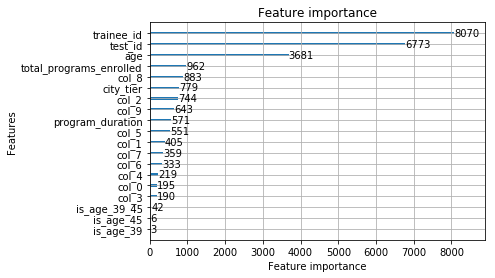

In [11]:
lgb.plot_importance(model)

## simple ensembles of my best models

In [26]:
df1 = pd.read_csv(f'{PATH}\\AV_Stud\\imp_subs\\01_05_18.csv')
df2 = submit.copy()

In [27]:
col = 'is_pass'
new_preds  = (df1[col] + df2[col])/2.

In [28]:
submit = make_submission(new_preds)

In [29]:
submit.head(2)

,id,is_pass
0,1626_45,0.340114
1,11020_130,0.930512


In [30]:
submit.to_csv(f'{PATH}\\AV_Stud\\01_05_18+02_05_18.csv', index=False)

In [31]:
df_raw['is_pass'] = target
df_raw.to_csv(f'{PATH}\\AV_Stud\\01_05_18_category_encoder_df_train.csv', index=False)
df_test.to_csv(f'{PATH}\\AV_Stud\\01_05_18_category_encoder_df_test.csv', index=False)
df_raw = df_raw.drop('is_pass', axis=1)

In [35]:
c = 0
for i in model:
    i.save_model(f'{PATH}\\AV_Stud\\xgb_{c}'.format(c))
    c+=1